# Classical Portfolio Optimization

This notebook is used to generate a portfolio of 10 random stocks from the AlphaVantage API and then optimize the portfolio weights using Markowitz theory. The optimization analysis can be performed using 3 years of historical stock data (2014-2017). 

The returns of the portfolio with and without optimization over a 3 year test timeframe can then be calculated (2017-2020). These results will be used as the baseline in which the optimization performed through supervised and unsupervised learning will be compared.

In order to perform the optimization, the stock data must be obtained, the **expected returns** must be calculated, the **variance** of the stock data must be calculated and the **effecient frontier** must be found.


## Obtaining stock data



### Getting stock names
The stock names can be found by obtaining an array of all the stocks in the S&P 500 index, generating 10 random numbers and then using those numbers to choose 10 array items.

In [6]:
#Taken from Automating getting the S&P 500 list - Python Programming for Finance p.5
# https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/

import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.strip("\n"))
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

save_sp500_tickers()
    

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'T',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

Next 10 random numbers between 0 and 504 can be generated in order to pick 10 random stock tickers from the list

In [7]:
import random

tickers = save_sp500_tickers()
print(len(tickers)) # there are actually 505 stocks in the S&P 500, who knew!

def getRandomTickers(tickers):
  randIndex = []
  randTickers = []
  for i in range(0,10):
    randIndex.append(random.randint(0,504))
  for index in randIndex:
    randTickers.append(tickers[index])
  return randTickers

print(getRandomTickers(tickers)) 


505
['IDXX', 'EQIX', 'NOC', 'CMS', 'ETN', 'WMB', 'PKG', 'COO', 'AMT', 'MMC']


Markowitz Analysis requires a vector of expected returns over the period of analysis for all of the stocks in the portfolio as well as the cauculation of the covariance matrix for the stocks. This can then be used to generate the portfolio weight vector omega.

The ffn library will be used to retrieve data for the random tickers generated from yahoo finance from March 26, 2010 to March 26, 2015.Then the preliminary Markowitz analysis can be conducted


In [8]:
#setup
%matplotlib inline

#need to add these packages to requirements.txt
!pip install empyrical ffn PyPortfolioOpt

#taken from https://github.com/Poseyy/MarketAnalysis/blob/master/portfolios/PortfolioAnalysis.ipynb
import ffn 
from empyrical import alpha_beta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
import matplotlib as pyplot
import numpy as np
import pandas as pd

In [0]:
#generate random portfolio
randomTickers = getRandomTickers(tickers)

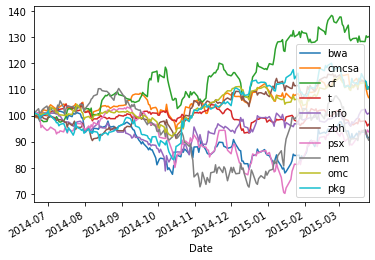

In [10]:
#retrieve price data for training period, plot data

prices = ffn.get(randomTickers,start='2010-03-26', end='2015-03-26')
ax = prices.rebase().plot()

Now we can plot the returns for this portfolio

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

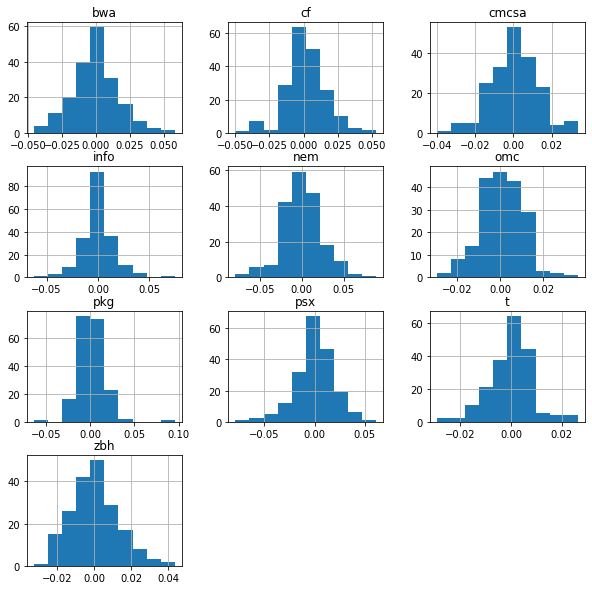

In [11]:
returns = prices.to_returns().dropna()
ax = returns.hist(figsize=(10,10))

In [12]:
#display stats for the portfolio
stats = prices.calc_stats()
stats.display()

Stat                 bwa         cmcsa       cf          t           info        zbh         psx         nem         omc         pkg
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2014-06-19  2014-06-19  2014-06-19  2014-06-19  2014-06-19  2014-06-19  2014-06-19  2014-06-19  2014-06-19  2014-06-19
End                  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -8.37%      6.91%       30.21%      -3.39%      0.86%       10.37%      -6.17%      -9.39%      10.33%      11.01%
Daily Sharpe         -0.28       0.55        1.55        -0.26       0.17        0.74        -0.11       -0.13       0.89        0.67
Daily Sortino        -0.49       0.91    

Calculate mean expected returns and covariance matrix for the price data (as per defaults specified in the PyPortfolioOpt docs https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html )

In [13]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(prices)
S = CovarianceShrinkage(prices).ledoit_wolf()
print("Mean expected returns: \n")
print(mu, "\n")
print("Covariance matrix: \n")
print(S, "\n")

Mean expected returns: 

bwa     -0.077158
cmcsa    0.105614
cf       0.373719
t       -0.035824
info     0.042072
zbh      0.148666
psx     -0.035407
nem     -0.051504
omc      0.140857
pkg      0.166329
dtype: float64 

Covariance matrix: 

            bwa     cmcsa        cf  ...       nem       omc       pkg
bwa    0.073097  0.020497  0.017892  ...  0.012641  0.021373  0.023153
cmcsa  0.020497  0.038941  0.007114  ...  0.007911  0.014864  0.015276
cf     0.017892  0.007114  0.058068  ...  0.014114  0.008350  0.014934
t      0.011473  0.008853  0.007786  ...  0.005718  0.006508  0.009053
info   0.021995  0.013100  0.006551  ...  0.001063  0.013612  0.009797
zbh    0.019516  0.016482  0.011121  ...  0.004204  0.014097  0.017793
psx    0.035885  0.017610  0.023425  ...  0.019597  0.016617  0.023146
nem    0.012641  0.007911  0.014114  ...  0.145990  0.001719  0.004161
omc    0.021373  0.014864  0.008350  ...  0.001719  0.028377  0.018696
pkg    0.023153  0.015276  0.014934  ...  0.004

Perform efficient frontier optimization using the max-sharpe ratio as the optimization parameter

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

#calculate efficient frontier
ef = EfficientFrontier(mu, S)

"""
use gamma parameter to reduce tendency of optimization to result in 0 asset weights, 
as this is detrimental to portfolio diversication

https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html#l2-regularisation

"""
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()

#use cleaned weights function to round data
cleaned_weights = ef.clean_weights()

#ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

#print expected performance
ef.portfolio_performance(verbose=True)

{'bwa': 0.0, 'cmcsa': 0.07525, 'cf': 0.50417, 't': 0.0, 'info': 0.0, 'zbh': 0.13825, 'psx': 0.0, 'nem': 0.0, 'omc': 0.15029, 'pkg': 0.13203}
Expected annual return: 26.0%
Annual volatility: 16.1%
Sharpe Ratio: 1.50


/usr/local/lib/python3.6/dist-packages/pypfopt/efficient_frontier.py:178: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


(0.2600504505652317, 0.16056738512219781, 1.4950137624932005)

Now that the weights have been generated for the portfolio, 
the weighted and unweighted portfolio performance can be tested over the period of 2015-2020. The performance of the two portfolios can be compared to determine if the optimization indeed will improve returns.

The annualized returns of the weighted portfolio can also be compared to the estimation provided by the PyPortfolioOpt library.

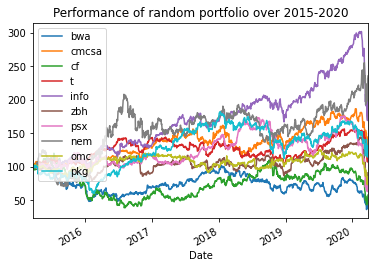

In [15]:
#obtain price data for test period
testPrices = pd.DataFrame()
testPrices = ffn.get(randomTickers,start='2015-03-26', end='2020-03-26')
ax = testPrices.rebase().plot(title="Performance of random portfolio over 2015-2020")

Now we can calulate annualized return, volatility and sharpe ratio for the unweighted and weighted portfolios

In [16]:
#https://towardsdatascience.com/optimizing-portfolios-with-modern-portfolio-theory-using-python-60ce9a597808 
print("Ticker Labels:")
print(randomTickers)
print("Equi-weighted portfolio weights:")
print(np.full(10,.1), "\n")
print("Optimized portfolio weights:")
print(list(cleaned_weights.values()), "\n")

opt_weights = list(cleaned_weights.values())
weights_arr = [np.full(10,.1), opt_weights]
returns_arr = []
volatility_arr = []

print(" --- Results --- ")
for weights in weights_arr:
  returns = prices.pct_change()
  
  # mean daily return and covariance of daily returns
  mean_daily_returns = returns.mean()
  cov_matrix = returns.cov()

  # portfolio weights
  weights = np.asarray(weights)
  
  portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
  portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

  returns_arr.append(portfolio_return)
  volatility_arr.append(portfolio_std_dev)

  if(weights[0] == .1):
    print("Equal weighted portfolio stats:")
  else:
    print("Optimized portfolio stats:")
  print("Annualised return: " + str(portfolio_return))
  print("Volatility: " + str(portfolio_std_dev) + "\n")

print("Percent change in return after optimization: " + str(((returns_arr[1] - returns_arr[0])/returns_arr[0])))
print("Percent change in volatility after optimization: " + str(((volatility_arr[1] - volatility_arr[0])/volatility_arr[0])))

Ticker Labels:
['BWA', 'CMCSA', 'CF', 'T', 'INFO', 'ZBH', 'PSX', 'NEM', 'OMC', 'PKG']
Equi-weighted portfolio weights:
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 

Optimized portfolio weights:
[0.0, 0.07525, 0.50417, 0.0, 0.0, 0.13825, 0.0, 0.0, 0.15029, 0.13203] 

 --- Results --- 
Equal weighted portfolio stats:
Annualised return: 0.08
Volatility: 0.14

Optimized portfolio stats:
Annualised return: 0.26
Volatility: 0.16

Percent change in return after optimization: 2.25
Percent change in volatility after optimization: 0.14285714285714277


# **--- Optimization Results ---**

**Percent change in returns:** 58.8%

**Percent change in risk:** -5%

As expected, the portfolio optimization not only increased annualized returns, but also slightly decreased volitility.

Now we can graph the performance of the two portfolios with respect to the individual securities to visualize their performance.

0    0.00000
1    0.07525
2    0.50417
3    0.00000
4    0.00000
5    0.13825
6    0.00000
7    0.00000
8    0.15029
9    0.13203
dtype: float64
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
dtype: float64
unweighted portfolio before finding sum:
            bwa      cmcsa         cf  ...        nem        omc       pkg
Date                                   ...                                
2015-03-26  0.0  25.488060  49.090107  ...  20.501591  66.032669  0.879389
2015-03-27  0.0  25.501743  48.157524  ...  20.566351  66.178741  0.884506
2015-03-30  0.0  25.923033  48.544575  ...  20.372072  67.055176  0.896559
2015-03-31  0.0  25.858921  47.326702  ...  20.085262  67.003609  0.889054
2015-04-01  0.0  26.129099  47.403439  ...  21.019688  66.745850  0.873135
...         ...        ...        ...  ...        ...        ...       ...
2020-03-20  0.0  33.369999  22.250000  ...  40.560001  49.509998  1.133874
2020-03-23  0.0  34.169998  22.040

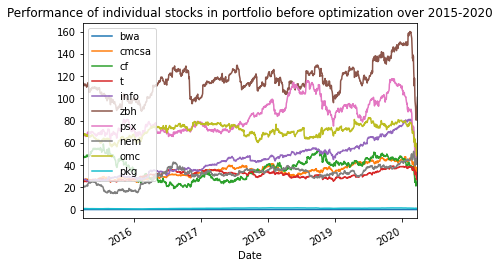

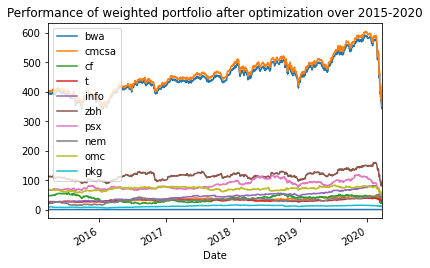

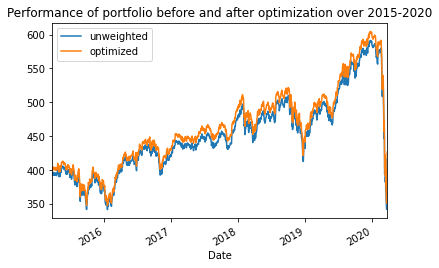

In [19]:

def multiplyWithPrice(row, weights):
  #print(row)
  #print(row.name)
  #print(row.values)
  #print(weights)
  #print(weights[row.name])
  modifiedRow = []
  for i in (0, len(row.values)-1):
    row.values[i] = row.values[i]*weights[i]
    #modifiedRow.append(row[i]*weights[row.name])
  #return modifiedRow
  return row

#print(cleaned_weights)
opt_weights_ser = pd.Series(opt_weights)
equal_weights_ser = pd.Series(np.full(10,.1))
print(opt_weights_ser)
print(equal_weights_ser)

#calculate weighted portfolio
temp = testPrices
w_portfolio = temp.apply(lambda row: multiplyWithPrice(row, opt_weights_ser), axis=1)

#calculate unweighted portfolio (still need to multiply everything by .1)
temp = testPrices
uw_portfolio = temp.apply(lambda row: multiplyWithPrice(row, equal_weights_ser), axis=1)

#plot all stocks in portfolios
ax1 = uw_portfolio.plot(title="Performance of individual stocks in portfolio before optimization over 2015-2020")
ax2 = w_portfolio.plot(title="Performance of individual stocks in portfolio after optimization over 2015-2020")


print("unweighted portfolio before finding sum:")
print(uw_portfolio)
uw_portfolio = uw_portfolio.sum(axis=1)

print("unweighted portfolio")
print(uw_portfolio)
ax3 = uw_portfolio.plot(title="Performance of unweighted portfolio over 2015-2020")


print("weighted portfolio before finding sum:")
print(w_portfolio)
w_portfolio = w_portfolio.sum(axis=1)

print("weighted portfolio")
print(w_portfolio)
ax4 = w_portfolio.plot(title="Performance of weighted portfolio after optimization over 2015-2020")




#first plot performance of two portfolios
portfolios = pd.concat([uw_portfolio, w_portfolio], axis=1, keys=['unweighted', 'optimized'])
print(portfolios)
ax4 = portfolios.plot(title="Performance of portfolio before and after optimization over 2015-2020")

#add portfolio data to price data
#testPrices['uw_portfolio'] = uw_portfolio
#testPrices['w_portfolio'] = w_portfolio

#plot new data
#ax = testPrices.plot(title="Performance of random portfolio over 2015-2020")

